
# CLUSTERING WITH REAL ESTATE DATA 
        by Karen Belita 
Clustering is a type of **Unsupervised Machine Learning**, which can determine relationships of unlabeled data.  
This notebook will show how to get and prepare data for exploration of clustering methods.  
This notebook will use scikit-learn for machine learning processes.
### Data information
Zillow has real estate data at different geographic levels.
This notebook will explore some clustering methods with the **Zillow Home Value Index** data set at the **City** level.

The data can be found [here](http://www.zillow.com/research/data/).

### Dependencies

In [1]:
import pandas as pd
import csv
import os 
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
#from pandas.tools.plotting import scatter_matrix
from __future__ import print_function
import urllib.request
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn import preprocessing
matplotlib.style.use('ggplot')
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler, Normalizer
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline 
import matplotlib.cm as cm
from sklearn.cluster import AgglomerativeClustering
import warnings
from sklearn.metrics import silhouette_samples, silhouette_score

### Getting Data
Use urllib to download the csv file from the site.

In [2]:
url = "http://files.zillowstatic.com/research/public/City/City_Zhvi_Summary_AllHomes.csv"

def csv_download():
    path = os.getcwd() ## current location
    file_name = path + "/" + "ZHVICity.csv"
    
    if os.path.isfile(file_name): # makes sure that no file duplicates
        pass
    else:
        f = urllib.request.urlopen(url)
        data = f.read()
        with open(file_name, "wb") as f:
            f.write(data)
    # return file_name to print location

csv_download()


### Preparing Data
Use pandas to prepare data for machine learning.


In [3]:
file_name = os.path.join(os.getcwd(), "ZHVICity.csv")

df = pd.read_csv(file_name)

Look at the structure of the data.

In [4]:
df.head()

,Date,RegionID,RegionName,State,Metro,County,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak,LastTimeAtCurrZHVI
0,2017-03-31,6181,New York,NY,New York,Queens,0,650000,0.013408,0.032402,0.129060,0.070806,0.023315,2017-03,2017-Q1,650000,0.000000,2017-03
1,2017-03-31,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1,622900,0.007766,0.020144,0.087655,0.106821,0.005033,2017-03,2017-Q1,622900,0.000000,2017-03
2,2017-03-31,17426,Chicago,IL,Chicago,Cook,2,220900,0.004091,0.026487,0.078613,0.058426,-0.011106,2007-01,2007-Q1,247300,-0.106753,2005-01
3,2017-03-31,13271,Philadelphia,PA,Philadelphia,Philadelphia,3,136100,0.005913,0.021005,0.088800,0.039377,0.014545,2017-03,2017-Q1,136100,0.000000,2017-03
4,2017-03-31,40326,Phoenix,AZ,Phoenix,Maricopa,4,208600,0.005786,0.019052,0.097317,0.136332,-0.014783,2006-07,2006-Q3,245700,-0.150997,2005-07


Rename the column "RegionName" to "City" and create a column that combines the name of city with its state for readability purposes.  
Also remove irrelevant columns.

In [5]:
#rename
df.rename(columns={"RegionName" : "City"},
          inplace = True) 
# add new column
df['City-State'] = df['City'] + "-" + df['State']
df.head(1)
##move new column to the front
cols = df.columns.tolist() 
cols.insert(0, cols.pop(cols.index('City-State'))) #move to position 0
#drop columns
df = df.reindex(columns = cols)
df.drop(df.columns[[0,1,6,18]], axis = 1, inplace = True)
df.head(2)

,RegionID,City,State,Metro,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak
0,6181,New York,NY,New York,0,650000,0.013408,0.032402,0.129060,0.070806,0.023315,2017-03,2017-Q1,650000,0.0
1,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,1,622900,0.007766,0.020144,0.087655,0.106821,0.005033,2017-03,2017-Q1,622900,0.0


Pandas can also help with describing the Data which can help for analysis.  
Such as Summarizing data by state (Average ZHVI data per state)...

In [6]:
statedf = df.groupby("State")["Zhvi"].mean().sort_values(ascending = False)
statedf.head()

State
CA    612531
HI    561834
DC    559200
MA    385613
NJ    377342
Name: Zhvi, dtype: int64

Select columns that will be used as features for Machine Learning.

In [7]:
featcol= [
    'Zhvi','MoM','QoQ','YoY','5Year','10Year','PeakZHVI','PctFallFromPeak']
x = df[featcol]


Dealing with missing values can be done by removing rows with missing data....

In [8]:
#check number of rows
print ("original number of rows:  %d" % (len(x.index)))

#remove rows
x1 = x.dropna()
print ("new number of rows:  %d" % (len(x1.index)))


original number of rows:  10893
new number of rows:  9571


Or imputating missing values with the interpolate function from pandas.

In [9]:
## all Nans to white space
x = x.replace(np.nan, ' ', regex = True)
x = x.replace(np.nan, 'NaN', regex = True)
## convert to all floats
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    x = x.convert_objects(convert_numeric = True)
x = x.interpolate()
x.isnull().any().any() ## to check if any missing data


False

Prepare features by converting the dataframe into an array.

In [10]:
# features into array
features = x.values

To see variance of features: boxplot (from Seaborn) can be used with the MinMaxscaler (from scikit-learn) to visualize this.

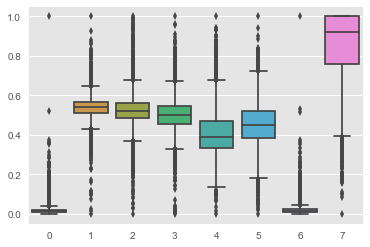

In [11]:
min_max_scaler = MinMaxScaler()
fmm = min_max_scaler.fit_transform(features)
fmX = pd.DataFrame(fmm)

ax = sns.boxplot(data=fmX)
ax

## Unsupervised Machine Learning with *Clustering*
Clustering can label the unlabeled Real Estate Data.

Below is a summary of the parameters used by the clustering algorithms from scikit-learn:

* K-Means: number of clusters
* Affinity propagation: damping, sample preference
* Means-shift: bandwidth
* Spectral Clustering: number of clusters
* Ward hierachical clustering: number of clusters
* DBSCAN: neighborhood size
* Gaussian mixtures: *there are many to choose from*
* Birch: branching factor, threshold, optional global clusterer


Read more about [Clustering with Scikit-Learn](http://scikit-learn.org/stable/modules/clustering.html#clustering).

**Start with K-means since it's simple.**  
Read more about [**K-Means**](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).  
The parameter that K-Means utilizes is the number of clusters or k.

Pick a number of clusters or k for K-Means, and check its performance by using the [silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), the metric that assesses the variance of objects within clusters. *Score closer to 1 is best.*

In [12]:
k = 4
cluster = KMeans(init='k-means++', n_clusters=k, n_init=12)
cluster.fit(features)
metrics.silhouette_score(features, cluster.labels_)

0.67514490830721008

**Model selection** can be done by looping through a range of k.
This could also include looping through different types of clustering methods that uses k or number of clusters as a parameter. 

The loop includes K-Means and the following clustering methods:  

* [**MiniBatch K-Means**](http://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans) is the same as K-means but uses mini-batches to reduce computation time 
* [**Agglomerative Clustering**](http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)  performs heirarchical clustering and can be used with 3 three different merge or linkage strategies : 
  * **Ward**
  * **Complete**
  * **Average**

The result of the loop is a ranking of the silhouette scores of the different methods and k explored.

*Pick a range of k to explore.*

In [13]:
# adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
range_n_clusters = range(8,11)
List1 = []
List2 = []
List3 = []
 
for n_clusters in range_n_clusters:
    def bench_clustering(estimator, name, data):
        estimator.fit(data)
        v1 = name 
        v2 = n_clusters
        v3 = metrics.silhouette_score(data, estimator.labels_)

        List1.append(v1)
        List2.append(v2)
        List3.append(v3)

    bench_clustering(KMeans(init='k-means++', n_clusters=n_clusters, n_init=12),
                  name="K-Means", data=features)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        bench_clustering(MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, n_init=12,max_no_improvement=10, verbose=0,random_state=0),
                     name="MiniBatchKMeans", data=features)
    bench_clustering(AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'),
                  name="Ward", data=features)   

    bench_clustering(AgglomerativeClustering(n_clusters=n_clusters, linkage='average'),
                  name="Average", data=features)  
    
    bench_clustering(AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'),
                  name="Complete", data=features) 
d = pd.DataFrame()
d['method'] = List1 
d['k'] = List2
d['silhouette_score'] = List3
d = d.sort_values(['silhouette_score'], ascending = False)
print (d)





             method   k  silhouette_score
3           Average   8          0.869141
8           Average   9          0.850578
13          Average  10          0.737894
0           K-Means   8          0.569374
2              Ward   8          0.542509
4          Complete   8          0.542509
12             Ward  10          0.539720
14         Complete  10          0.539720
7              Ward   9          0.539631
9          Complete   9          0.539631
5           K-Means   9          0.534215
10          K-Means  10          0.522625
6   MiniBatchKMeans   9          0.481316
11  MiniBatchKMeans  10          0.474331
1   MiniBatchKMeans   8          0.451215


[**Silhouette plot analysis**](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) can also aid with model selection. The relationship of objects within each cluster can be assessed visually.  

*Pick a range of k to explore.* (Below is used with K-Means, but can be used with the other clustering methods that use k as a parameter, as mentioned above.)

For n_clusters = 8 The average silhouette_score is : 0.569374256213


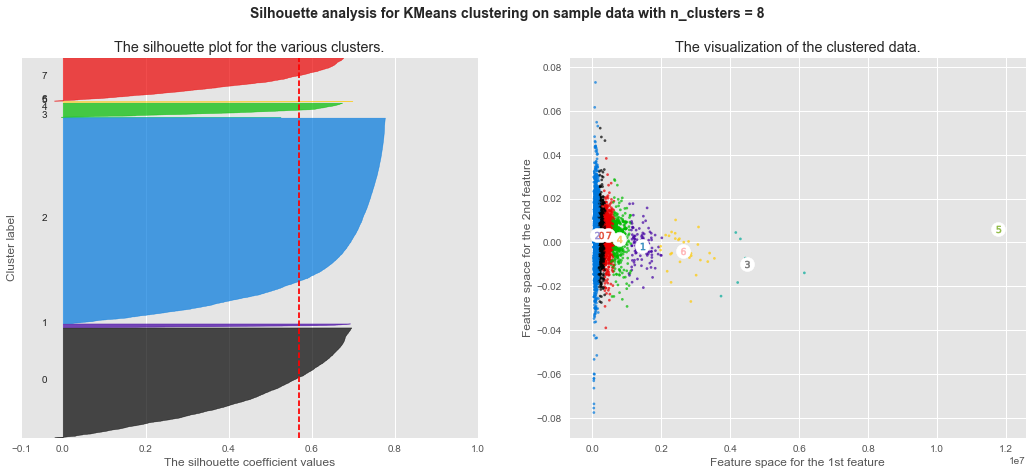

For n_clusters = 9 The average silhouette_score is : 0.530796596903


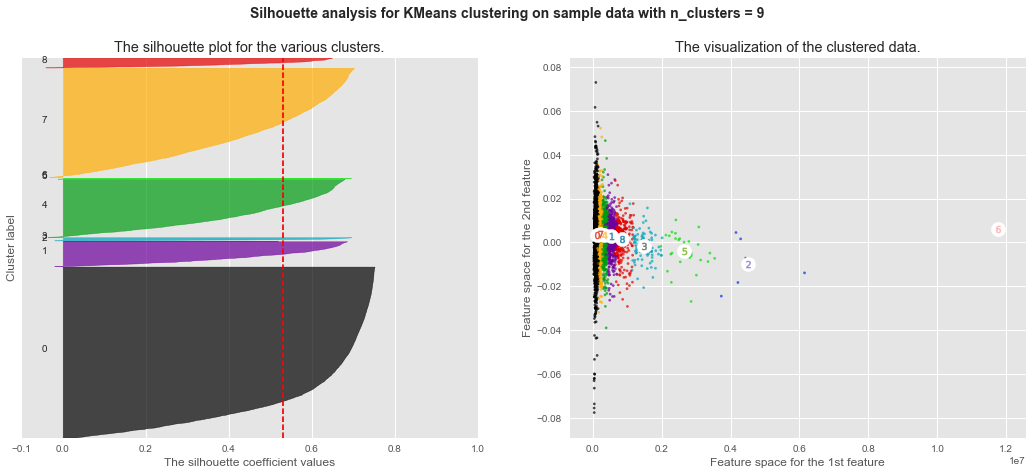

For n_clusters = 10 The average silhouette_score is : 0.515566366619


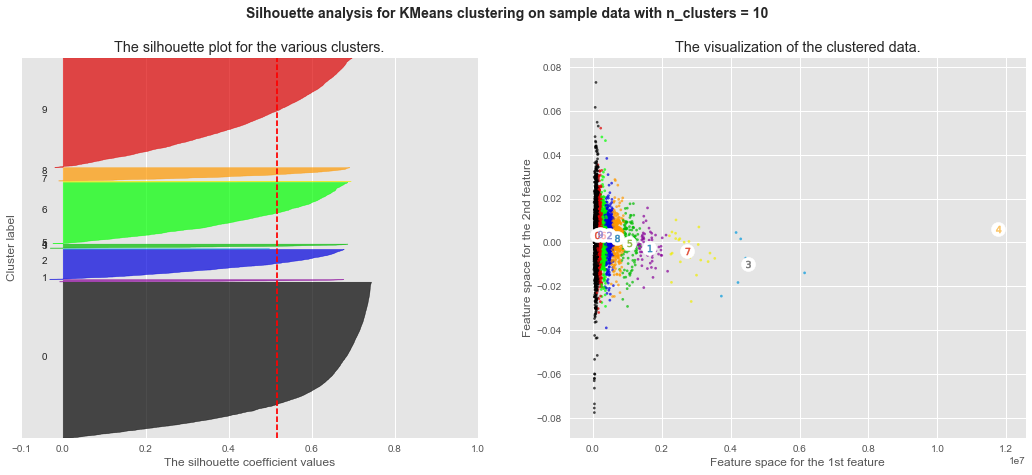

In [14]:
#adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

range_n_clusters = range(8,11)

for n_clusters in range_n_clusters:
    
    cluster = KMeans(init='k-means++', n_clusters=n_clusters, n_init=12)
    cluster.fit(features)
    metrics.silhouette_score(features, cluster.labels_)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(features) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster
    cluster_labels = clusterer.fit_predict(features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(features[:, 0], features[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

**Visualizing Clusters** - 
The example below shows the clusters and their centroids.
Seeing the shape of the clusters and the location of the centroids can help with further analysis.

*Pick a k to explore.* (Below is used with K-Means, but can be used with the other clustering methods that use k as a parameter, as mentioned above.)


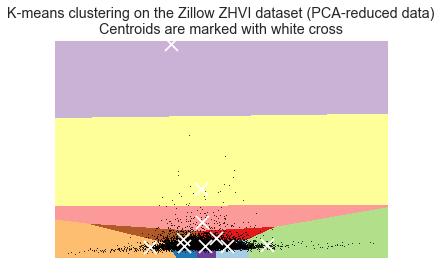

In [15]:
#adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

n_clusters = 10
f_scaled = scale(features)
reduced_data = PCA(n_components=2).fit_transform(f_scaled)
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the Zillow ZHVI dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


# *Not getting good silhouette scores?*
Try adding more features from [Zillow/data](http://www.zillow.com/research/data/).  
There are also many other clustering methods with scikit-learn to explore [here](http://scikit-learn.org/stable/modules/clustering.html#clustering).